In [1]:
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import copy

In [3]:
from matplotlib.colors import LogNorm
from matplotlib import cm

In [4]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, concatenate, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Input, LeakyReLU, Dense, Activation
from tensorflow.keras.layers import MaxPooling2D, Reshape

In [5]:
from tensorflow.keras.utils import to_categorical, plot_model

In [6]:
from tensorflow.keras.layers import ZeroPadding2D

In [7]:
from tensorflow.keras.utils import to_categorical, plot_model

In [8]:
import tensorflow.keras.callbacks

In [9]:
class haltCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.15):
            self.model.stop_training = True

### Training

In [10]:
import h5py

In [53]:
def make_amp_phs_only_model(input_shape, nlayer=3):
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="same", input_shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="same"))
    model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="same"))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(LeakyReLU())
    
    for layer in range(1,nlayer):
        nfilters = 16*2**layer
        model.add(Conv2D(filters=nfilters,kernel_size=3, strides=1, padding="same"))
        model.add(Conv2D(filters=nfilters, kernel_size=3, strides=1, padding="same"))
        model.add(Conv2D(filters=nfilters, kernel_size=3, strides=1, padding="same"))
        model.add(MaxPooling2D(pool_size=2, strides=2))
        model.add(LeakyReLU())
    
    for layer in range(nlayer):
        model.add(Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same'))

    model.add(BatchNormalization())
    model.add(Activation("softmax"))
    
    return model

In [40]:
def make_amp_phs_model(input_shape, nlayer=3):
    amp_input = Input(shape=input_shape, name="amp_input")
    phs_input = Input(shape=input_shape, name="phs_input")

    # amplitude branch
    ca1 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(amp_input)
    ca2 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(ca1)
    ca3 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(ca2)
    ma1 = MaxPooling2D(pool_size=2, strides=2)(ca3)
    la1 = LeakyReLU()(ma1)
    
    for layer in range(1,nlayer):
        ca4 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(la1)
        ca5 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(ca4)
        ca6 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(ca5)
        ma2 = MaxPooling2D(pool_size=2, strides=2)(ca6)
        la2 = LeakyReLU()(ma2)
        la1 = la2

    # phase branch
    cp1 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(phs_input)
    cp2 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(cp1)
    cp3 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(cp2)
    mp1 = MaxPooling2D(pool_size=2, strides=2)(cp3)
    lp1 = LeakyReLU()(mp1)
    
    for layer in range(1,nlayer):
        cp4 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(lp1)
        cp5 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp4)
        cp6 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp5)
        mp2 = MaxPooling2D(pool_size=2, strides=2)(cp6)
        lp2 = LeakyReLU()(mp2)
        lp1 = lp2
    
    # concatenate
    concat = concatenate([la1, lp1])

    # transpose layers
    for layer in range(nlayer):
        tr1 = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same')(concat)
        concat = tr1
   
    bn1 = BatchNormalization()(tr1)
    act = Activation("softmax")(bn1)
    
    # build the model
    model = Model(inputs=[amp_input, phs_input], outputs=[act])
    
    return model

In [11]:
def keras_convert_wf(wf, Nt_min=64, Nf_min=64):
    """Convert an input waterfall to the correct type expected by the Keras model.
    Due to the max pooling in the Keras model, we may need to pad the input
    waterfall to be the correct shape. This padding will be done symmetrically
    on both ends of the waterfall.
    Parameters
    ----------
    wf : ndarray
        A 3d ndarray of shape (Nbatch, Ntimes, Nfreq) and complex dtype. Will
        be padded if dimension aare not sufficient for the given input.
    Nt_min : int
        The minimum size of the waterfall along the time dimension.
    Nf_min : int
        The minimum size of the waterfall along the frequency dimension.
    Returns
    -------
    wf_amp : ndarray
        A 4d ndarray of shape (Nbatch, Ntimes', Nfreq', 1) and real dtype.
        Ntimes' and Nfreq' will be padded if they are not sufficiently
        large for the given model. The last axis is log10(amp) of the
        input complex number.
    wf_phs : ndarray
        A 4d ndarray of shape (Nbatch, Ntimes', Nfreq', 1) and real dtype.
        Ntimes' and Nfreq' will be padded if they are not sufficiently
        large for the given model. The last axis is phase (angle) of the
        input complex number.
    """
    if len(wf.shape) != 3:
        raise ValueError("wf should be a 3-dimensional ndarray")
    if wf.dtype not in (np.complex, np.complex64, np.complex128):
        raise ValueError("wf should have a complex dtype")
    input_shape = wf.shape
    # convert to amplitude and phase
    wf_amp = np.empty((*input_shape, 1), dtype=np.float)
    wf_phs = np.empty((*input_shape, 1), dtype=np.float)

    wf_amp[:, :, :, 0] = np.log10(np.abs(wf))
    wf_phs[:, :, :, 0] = np.angle(wf)

    # clean up potential NaNs
    minval = np.amin(wf_amp)
    wf_amp = np.where(np.isnan(wf_amp), minval, wf_amp)
    if np.any(np.isnan(wf_amp)):
        raise AssertionError("NaN values present in input waterfall")

    # maybe pad times
    if input_shape[1] < Nt_min:
        # pad it out
        diff = Nt_min - input_shape[1]
        Npad_l = diff // 2
        Npad_r = diff // 2 + diff % 2  # extra 1 in case difference is odd
        wf_amp = np.pad(wf_amp, ((0, 0), (Npad_l, Npad_r), (0, 0), (0, 0)), mode="reflect")
        wf_phs = np.pad(wf_phs, ((0, 0), (Npad_l, Npad_r), (0, 0), (0, 0)), mode="reflect")

    # maybe pad freqs
    if input_shape[2] < Nf_min:
        # pad it out
        diff = Nf_min - input_shape[2]
        Npad_l = diff // 2
        Npad_r = diff // 2 + diff % 2  # extra 1 in case difference is odd
        wf_amp = np.pad(wf_amp, ((0, 0), (0, 0), (Npad_l, Npad_r), (0, 0)), mode="reflect")
        wf_phs = np.pad(wf_phs, ((0, 0), (0, 0), (Npad_r, Npad_r), (0, 0)), mode="reflect")

    return wf_amp, wf_phs


def keras_convert_flags(flags, Nt_min=64, Nf_min=64):
    """Convert an input flag array to the correct type expected by the Keras model.
    Due to the max pooling in the Keras model, we may need to pad the input
    flags to be the correct shape. This padding will be done symmetrically
    on both ends of the flag waterfall.
    Parameters
    ----------
    flags : ndarray
        A 3d ndarray of shape (Nbatch, Ntimes, Nfreq) and boolean dtype. Will
        be padded if dimension aare not sufficient for the given input.
    Nt_min : int
        The minimum size of the waterfall along the time dimension.
    Nf_min : int
        The minimum size of the waterfall along the frequency dimension.
    Returns
    -------
    flags_out : ndarray
        A 4d ndarray of shape (Nbatch, Ntimes', Nfreq', 1) and integer dtype.
        Ntimes' and Nfreq' will be padded if they are not sufficiently
        large for the given model.
    """
    if len(flags.shape) != 3:
        raise ValueError("flags should be a 3-dimensional ndarray")
    input_shape = flags.shape
    # convert to int
    flags_out = flags.astype(np.int32).reshape((*input_shape, 1))

    # maybe pad times
    if input_shape[1] < Nt_min:
        # pad it out
        diff = Nt_min - input_shape[1]
        Npad_l = diff // 2
        Npad_r = diff // 2 + diff % 2  # extra 1 in case difference is odd
        flags_out = np.pad(
            flags_out, ((0, 0), (Npad_l, Npad_r), (0, 0), (0, 0)), mode="reflect"
        )

    # maybe pad freqs
    if input_shape[2] < Nf_min:
        # pad it out
        diff = Nf_min - input_shape[2]
        Npad_l = diff // 2
        Npad_r = diff // 2 + diff % 2  # extra 1 in case difference is odd
        flags_out = np.pad(
            flags_out, ((0, 0), (Npad_l, Npad_r), (0, 0), (0, 0)), mode="reflect"
        )
    #flags_out = to_categorical(flags_out)
    return flags_out

In [12]:
def keras_recall_metric(y_true, y_pred):
    """Define a recall metric to use in Keras.
    Parameters
    ----------
    y_true : ndarray
        The "true" values according to Keras.
    y_pred : ndarray
        The "predicted" values according to Keras.
    Returns
    -------
    recall : float
        The recall value, defined as the number true positives divided by the
        total number of positives.
    """
    y_pred = K.cast_to_floatx(K.argmax(y_pred, axis=-1))
    y_true = K.squeeze(y_true, -1)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def keras_precision_metric(y_true, y_pred):
    """Define a precision metric to use in Keras.
    Parameters
    ----------
    y_true : ndarray
        The "true" values according to Keras.
    y_pred : ndarray
        The "predicted" values according to Keras.
    Returns
    -------
    precision : float
        The precision value, defined as the number of true positives divided
        by the number of predicted positives.
    """
    y_pred = K.cast_to_floatx(K.argmax(y_pred, axis=-1))
    y_true = K.squeeze(y_true, -1)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def keras_f2_metric(y_true, y_pred):
    """Define a F2 metric to use in Keras.
    Parameters
    ----------
    y_true : ndarray
        The "true" values according to Keras.
    y_pred : ndarray
        The "predicted" values according to Keras.
    Returns
    -------
    f2 : float
        The F2 metric, which is a weighted combination of the precision and
        recall metrics. The F2 score weights recall higher than precision, which
        places a greater emphasis on false negatives.
    """
    precision = keras_precision_metric(y_true, y_pred)
    recall = keras_recall_metric(y_true, y_pred)
    f2 = (
        (1 + 2 ** 2)
        * (precision * recall)
        / (2 ** 2 * precision + recall + K.epsilon())
    )
    return f2

In [13]:
data_fn, n_train, n_test, Nt_min, Nf_min = '/data4/jkerrigan/ml_rfi/SimVis_3000_v13.h5',2000,200,64,64
"""Load the data and make sure it's the right size.
Parameters
----------
data_fn : str
    The full path to the data to use for training and testing.
n_train : int
    The number of samples to use as training data.
n_test : int
    The number of samples to use as testing/evaluation data.
Nt_min : int
    The minimum number of elements in the time (first) dimension of
    the waterfall required by the network. This argument will be passed
    to the keras_convert_wf function and keras_convert_flags function.
Nf_min : int
    The minimum number of elements in the frequency (second) dimension of
    the waterfall required by the network. This argument will be passed
    to the keras_convert_wf function and keras_convert_flags function.
Returns
-------
None
Notes
-----
This method will save the training and testing data on the object.
Raises
------
AssertionError
    This is raised if the training data and flags are not the same size,
    or if the testing data and flags are not the same size.
"""

"Load the data and make sure it's the right size.\nParameters\n----------\ndata_fn : str\n    The full path to the data to use for training and testing.\nn_train : int\n    The number of samples to use as training data.\nn_test : int\n    The number of samples to use as testing/evaluation data.\nNt_min : int\n    The minimum number of elements in the time (first) dimension of\n    the waterfall required by the network. This argument will be passed\n    to the keras_convert_wf function and keras_convert_flags function.\nNf_min : int\n    The minimum number of elements in the frequency (second) dimension of\n    the waterfall required by the network. This argument will be passed\n    to the keras_convert_wf function and keras_convert_flags function.\nReturns\n-------\nNone\nNotes\n-----\nThis method will save the training and testing data on the object.\nRaises\n------\nAssertionError\n    This is raised if the training data and flags are not the same size,\n    or if the testing data an

In [14]:
"""
# save attributes
with h5py.File(data_fn, "r") as f:
    train_data = f["data"][: n_train, :, :]
    train_flag = f["flag"][: n_train, :,:]
    test_data = f["data"][n_train : n_train + n_test, :, :]
    test_flag = f["flag"][n_train : n_train + n_test, :,:]
"""

'\n# save attributes\nwith h5py.File(data_fn, "r") as f:\n    train_data = f["data"][: n_train, :, :]\n    train_flag = f["flag"][: n_train, :,:]\n    test_data = f["data"][n_train : n_train + n_test, :, :]\n    test_flag = f["flag"][n_train : n_train + n_test, :,:]\n'

In [16]:
uvd = UVData()
uvd.read_uvh5('/data4/jrtan/RFI_sim/HERA19Golden_RFIsim_zen.2457755.71759.HH.uvh5')

In [17]:
uvd.Ntimes

61

In [18]:
uvd.Nbls

120

In [19]:
data_array = uvd.data_array[:, 0, :, 0].reshape(uvd.Ntimes, uvd.Nbls, uvd.Nfreqs).transpose((1,0,2))

In [20]:
train_data = data_array[:100,:,:]
test_data = data_array[100:,:,:]

In [21]:
flag_array = uvd.flag_array[:, 0, :, 0].reshape(uvd.Ntimes, uvd.Nbls, uvd.Nfreqs).transpose((1,0,2))

In [22]:
train_flag = flag_array[:100,:,:]
test_flag = flag_array[100:,:,:]

In [23]:
# resize data as necessary

train_data_amp, train_data_phs = keras_convert_wf(
    train_data, Nt_min=Nt_min, Nf_min=Nf_min,
)

test_data_amp, test_data_phs = keras_convert_wf(
    test_data, Nt_min=Nt_min, Nf_min=Nf_min
)

train_flag = keras_convert_flags(train_flag, Nt_min=Nt_min, Nf_min=Nf_min)

test_flag = keras_convert_flags(test_flag, Nt_min=Nt_min, Nf_min=Nf_min)

# make sure things are the right size/shape
assert train_data_amp.shape == train_data_phs.shape
assert train_data_amp.shape[:-1] == train_flag.shape[:-1]
assert test_data_amp.shape == test_data_phs.shape
assert test_data_amp.shape[:-1] == test_flag.shape[:-1]

In [24]:
def keras_unpad_flags(flags, Nt_out=64, Nf_out=1024):
    """Extract predicted flags from Keras model.

    Parameters
    ----------
    flags : ndarray
        The predicted flags from the Keras model.
    Nt_out : int
        The target number of times to extract in the first (time) dimension.
    Nf_out : int
        The target number of frequencies to extract in the second (frequency)
        dimension.

    Returns
    -------
    flags_out : ndarray
        The flags array reduced to size (Nt_out, Nf_out).
    """
    flags_shape = flags.shape
    if len(flags_shape) != 4:
        raise ValueError("flags must be a 4-dimensional array")
    Npad_t = flags_shape[1] - Nt_out
    t_start = Npad_t // 2
    Npad_f = flags_shape[2] - Nf_out
    f_start = Npad_f // 2
    flags_out = flags[:, t_start : t_start + Nt_out, f_start : f_start + Nf_out, :]
    flags_out = np.argmax(flags_out, axis=-1)
    return flags_out

### Build network

In [25]:
input_shape=train_data_amp.shape[1:]

### amplitude input with three `layer':

In [54]:
amp_model = make_amp_phs_only_model(input_shape, nlayer=3)

In [56]:
amp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 64, 1024, 16)      160       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 1024, 16)      2320      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 64, 1024, 16)      2320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 512, 16)       0         
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 32, 512, 16)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 512, 32)       4640      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 512, 32)       9

In [58]:
amp_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss="sparse_categorical_crossentropy",
         metrics=["sparse_categorical_accuracy",keras_recall_metric,keras_precision_metric, keras_f2_metric]) 

In [59]:
trainingStopCallback = haltCallback()
amp_model.fit(
    train_data_amp,
    train_flag,
    validation_data=(test_data_amp, test_flag),
    epochs=200,
    batch_size=32
)

Train on 100 samples, validate on 20 samples
Epoch 1/200
100/100 [==============================] - 2s 17ms/sample - loss: 0.8587 - sparse_categorical_accuracy: 0.5409 - keras_recall_metric: 0.4478 - keras_precision_metric: 0.2253 - keras_f2_metric: 0.3689 - val_loss: 0.6946 - val_sparse_categorical_accuracy: 0.5783 - val_keras_recall_metric: 0.4299 - val_keras_precision_metric: 0.2470 - val_keras_f2_metric: 0.3744
Epoch 2/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.7749 - sparse_categorical_accuracy: 0.6198 - keras_recall_metric: 0.3654 - keras_precision_metric: 0.2419 - keras_f2_metric: 0.3286 - val_loss: 0.6892 - val_sparse_categorical_accuracy: 0.7024 - val_keras_recall_metric: 0.2150 - val_keras_precision_metric: 0.2840 - val_keras_f2_metric: 0.2260
Epoch 3/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.7490 - sparse_categorical_accuracy: 0.6078 - keras_recall_metric: 0.3617 - keras_precision_metric: 0.2491 - keras_f2_metric: 0.33

Epoch 23/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.5898 - sparse_categorical_accuracy: 0.7524 - keras_recall_metric: 0.5237 - keras_precision_metric: 0.4578 - keras_f2_metric: 0.5085 - val_loss: 0.6383 - val_sparse_categorical_accuracy: 0.7947 - val_keras_recall_metric: 0.1317 - val_keras_precision_metric: 0.7360 - val_keras_f2_metric: 0.1576
Epoch 24/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.5834 - sparse_categorical_accuracy: 0.7639 - keras_recall_metric: 0.5036 - keras_precision_metric: 0.4943 - keras_f2_metric: 0.5008 - val_loss: 0.6345 - val_sparse_categorical_accuracy: 0.7949 - val_keras_recall_metric: 0.1172 - val_keras_precision_metric: 0.7869 - val_keras_f2_metric: 0.1412
Epoch 25/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.5780 - sparse_categorical_accuracy: 0.7570 - keras_recall_metric: 0.5497 - keras_precision_metric: 0.4754 - keras_f2_metric: 0.5329 - val_loss: 0.6311 - val_sparse_categori

Epoch 45/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4578 - sparse_categorical_accuracy: 0.8037 - keras_recall_metric: 0.6658 - keras_precision_metric: 0.5473 - keras_f2_metric: 0.6379 - val_loss: 0.5466 - val_sparse_categorical_accuracy: 0.8138 - val_keras_recall_metric: 0.4339 - val_keras_precision_metric: 0.6215 - val_keras_f2_metric: 0.4617
Epoch 46/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4545 - sparse_categorical_accuracy: 0.8054 - keras_recall_metric: 0.6858 - keras_precision_metric: 0.5601 - keras_f2_metric: 0.6563 - val_loss: 0.5395 - val_sparse_categorical_accuracy: 0.8164 - val_keras_recall_metric: 0.4744 - val_keras_precision_metric: 0.6180 - val_keras_f2_metric: 0.4976
Epoch 47/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4509 - sparse_categorical_accuracy: 0.8068 - keras_recall_metric: 0.6708 - keras_precision_metric: 0.5658 - keras_f2_metric: 0.6461 - val_loss: 0.5380 - val_sparse_categori

Epoch 67/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4016 - sparse_categorical_accuracy: 0.8164 - keras_recall_metric: 0.6079 - keras_precision_metric: 0.5917 - keras_f2_metric: 0.6044 - val_loss: 0.4727 - val_sparse_categorical_accuracy: 0.8046 - val_keras_recall_metric: 0.5834 - val_keras_precision_metric: 0.5620 - val_keras_f2_metric: 0.5790
Epoch 68/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4006 - sparse_categorical_accuracy: 0.8046 - keras_recall_metric: 0.5977 - keras_precision_metric: 0.5780 - keras_f2_metric: 0.5933 - val_loss: 0.4434 - val_sparse_categorical_accuracy: 0.8302 - val_keras_recall_metric: 0.5147 - val_keras_precision_metric: 0.6542 - val_keras_f2_metric: 0.5376
Epoch 69/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3969 - sparse_categorical_accuracy: 0.8155 - keras_recall_metric: 0.5958 - keras_precision_metric: 0.6014 - keras_f2_metric: 0.5965 - val_loss: 0.4580 - val_sparse_categori

Epoch 89/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3666 - sparse_categorical_accuracy: 0.8341 - keras_recall_metric: 0.5562 - keras_precision_metric: 0.6386 - keras_f2_metric: 0.5708 - val_loss: 0.4019 - val_sparse_categorical_accuracy: 0.8438 - val_keras_recall_metric: 0.5044 - val_keras_precision_metric: 0.7149 - val_keras_f2_metric: 0.5360
Epoch 90/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3670 - sparse_categorical_accuracy: 0.8358 - keras_recall_metric: 0.5699 - keras_precision_metric: 0.6917 - keras_f2_metric: 0.5898 - val_loss: 0.4228 - val_sparse_categorical_accuracy: 0.8120 - val_keras_recall_metric: 0.5368 - val_keras_precision_metric: 0.5886 - val_keras_f2_metric: 0.5465
Epoch 91/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3653 - sparse_categorical_accuracy: 0.8370 - keras_recall_metric: 0.5682 - keras_precision_metric: 0.6495 - keras_f2_metric: 0.5823 - val_loss: 0.4091 - val_sparse_categori

Epoch 111/200
100/100 [==============================] - 1s 5ms/sample - loss: 0.3430 - sparse_categorical_accuracy: 0.8654 - keras_recall_metric: 0.5634 - keras_precision_metric: 0.7888 - keras_f2_metric: 0.5974 - val_loss: 0.3800 - val_sparse_categorical_accuracy: 0.8347 - val_keras_recall_metric: 0.5414 - val_keras_precision_metric: 0.6602 - val_keras_f2_metric: 0.5616
Epoch 112/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3415 - sparse_categorical_accuracy: 0.8569 - keras_recall_metric: 0.5697 - keras_precision_metric: 0.7362 - keras_f2_metric: 0.5967 - val_loss: 0.3849 - val_sparse_categorical_accuracy: 0.8307 - val_keras_recall_metric: 0.5340 - val_keras_precision_metric: 0.6490 - val_keras_f2_metric: 0.5537
Epoch 113/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3398 - sparse_categorical_accuracy: 0.8572 - keras_recall_metric: 0.5661 - keras_precision_metric: 0.7362 - keras_f2_metric: 0.5934 - val_loss: 0.3862 - val_sparse_categ

Epoch 133/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3264 - sparse_categorical_accuracy: 0.8737 - keras_recall_metric: 0.5741 - keras_precision_metric: 0.8235 - keras_f2_metric: 0.6109 - val_loss: 0.3650 - val_sparse_categorical_accuracy: 0.8533 - val_keras_recall_metric: 0.5368 - val_keras_precision_metric: 0.7377 - val_keras_f2_metric: 0.5677
Epoch 134/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3255 - sparse_categorical_accuracy: 0.8805 - keras_recall_metric: 0.5687 - keras_precision_metric: 0.8376 - keras_f2_metric: 0.6072 - val_loss: 0.3649 - val_sparse_categorical_accuracy: 0.8521 - val_keras_recall_metric: 0.5358 - val_keras_precision_metric: 0.7327 - val_keras_f2_metric: 0.5662
Epoch 135/200
100/100 [==============================] - 1s 5ms/sample - loss: 0.3238 - sparse_categorical_accuracy: 0.8761 - keras_recall_metric: 0.5687 - keras_precision_metric: 0.8440 - keras_f2_metric: 0.6084 - val_loss: 0.3656 - val_sparse_categ

Epoch 155/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3131 - sparse_categorical_accuracy: 0.8851 - keras_recall_metric: 0.5714 - keras_precision_metric: 0.8815 - keras_f2_metric: 0.6146 - val_loss: 0.3496 - val_sparse_categorical_accuracy: 0.8637 - val_keras_recall_metric: 0.5350 - val_keras_precision_metric: 0.7892 - val_keras_f2_metric: 0.5719
Epoch 156/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3125 - sparse_categorical_accuracy: 0.8802 - keras_recall_metric: 0.5865 - keras_precision_metric: 0.8580 - keras_f2_metric: 0.6258 - val_loss: 0.3669 - val_sparse_categorical_accuracy: 0.8430 - val_keras_recall_metric: 0.5502 - val_keras_precision_metric: 0.6872 - val_keras_f2_metric: 0.5730
Epoch 157/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3127 - sparse_categorical_accuracy: 0.8848 - keras_recall_metric: 0.5847 - keras_precision_metric: 0.8997 - keras_f2_metric: 0.6285 - val_loss: 0.3472 - val_sparse_categ

Epoch 177/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3099 - sparse_categorical_accuracy: 0.8842 - keras_recall_metric: 0.5989 - keras_precision_metric: 0.8886 - keras_f2_metric: 0.6404 - val_loss: 0.3484 - val_sparse_categorical_accuracy: 0.8663 - val_keras_recall_metric: 0.5064 - val_keras_precision_metric: 0.8315 - val_keras_f2_metric: 0.5494
Epoch 178/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3092 - sparse_categorical_accuracy: 0.8693 - keras_recall_metric: 0.5993 - keras_precision_metric: 0.8077 - keras_f2_metric: 0.6318 - val_loss: 0.3607 - val_sparse_categorical_accuracy: 0.8342 - val_keras_recall_metric: 0.5512 - val_keras_precision_metric: 0.6549 - val_keras_f2_metric: 0.5692
Epoch 179/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3073 - sparse_categorical_accuracy: 0.8733 - keras_recall_metric: 0.5765 - keras_precision_metric: 0.8223 - keras_f2_metric: 0.6130 - val_loss: 0.3488 - val_sparse_categ

Epoch 199/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3040 - sparse_categorical_accuracy: 0.8772 - keras_recall_metric: 0.5849 - keras_precision_metric: 0.8000 - keras_f2_metric: 0.6177 - val_loss: 0.3614 - val_sparse_categorical_accuracy: 0.8566 - val_keras_recall_metric: 0.5443 - val_keras_precision_metric: 0.7475 - val_keras_f2_metric: 0.5756
Epoch 200/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3011 - sparse_categorical_accuracy: 0.8832 - keras_recall_metric: 0.5907 - keras_precision_metric: 0.8333 - keras_f2_metric: 0.6266 - val_loss: 0.3617 - val_sparse_categorical_accuracy: 0.8505 - val_keras_recall_metric: 0.5505 - val_keras_precision_metric: 0.7170 - val_keras_f2_metric: 0.5773


In [60]:
flags = amp_model.predict(test_data_amp)
flags_out = keras_unpad_flags(flags)[:,:,:,None]

Text(0.5, 1.0, '31.60% ML Flags not Manual Flags')

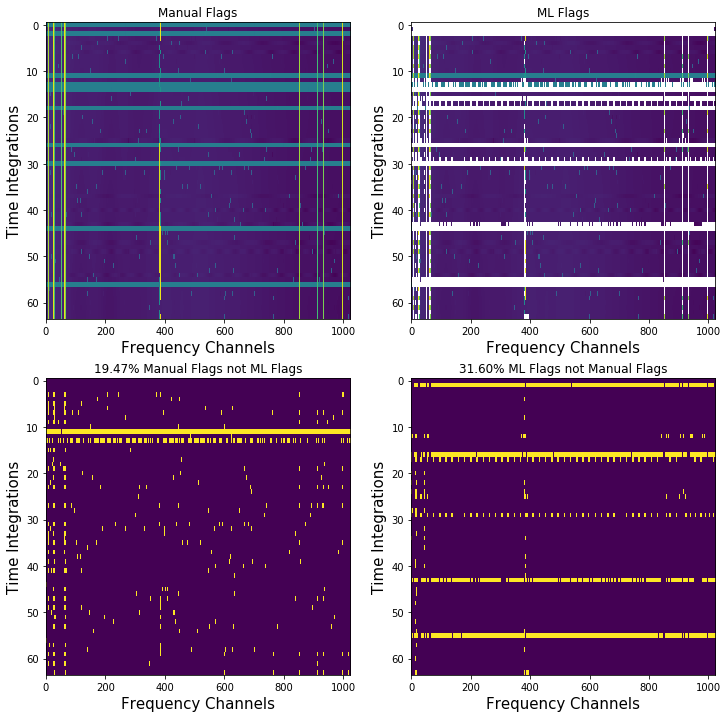

In [61]:
fig, axes = plt.subplots(figsize=(12,12), ncols=2, nrows=2)
ax = axes[0,0]
nan_array = np.ones_like(test_flag).astype(np.float64)
nan_array[test_flag == 1] = np.nan
ax.imshow(test_data_amp[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("Manual Flags")

ax = axes[0,1]
nan_array = np.ones_like(flags_out).astype(np.float64)
nan_array[flags_out == 1] = np.nan
ax.imshow((test_data_amp*nan_array)[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("ML Flags")

ax = axes[1,0]
ax.imshow(test_flag[0,:,:,0]*(1-flags_out[0,:,:,0]), aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
recall = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(test_flag[0,:,:,0])
ax.set_title("{0:.2f}% Manual Flags not ML Flags".format((1-recall)*100))

ax = axes[1,1]
ax.imshow((1-test_flag[0,:,:,0])*flags_out[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
precision = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(flags_out[0,:,:,0])
ax.set_title("{0:.2f}% ML Flags not Manual Flags".format((1-precision)*100))

### phase input with three `layer':

In [63]:
trainingStopCallback = haltCallback()
amp_model.fit(
    train_data_phs,
    train_flag,
    validation_data=(test_data_phs, test_flag),
    epochs=200,
    batch_size=32
)

Train on 100 samples, validate on 20 samples
Epoch 1/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.6600 - sparse_categorical_accuracy: 0.7558 - keras_recall_metric: 0.3076 - keras_precision_metric: 0.4726 - keras_f2_metric: 0.3294 - val_loss: 0.8595 - val_sparse_categorical_accuracy: 0.7430 - val_keras_recall_metric: 0.3909 - val_keras_precision_metric: 0.4213 - val_keras_f2_metric: 0.3967
Epoch 2/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.5278 - sparse_categorical_accuracy: 0.7815 - keras_recall_metric: 0.2486 - keras_precision_metric: 0.5140 - keras_f2_metric: 0.2770 - val_loss: 0.9066 - val_sparse_categorical_accuracy: 0.7598 - val_keras_recall_metric: 0.3427 - val_keras_precision_metric: 0.4529 - val_keras_f2_metric: 0.3602
Epoch 3/200
100/100 [==============================] - 1s 5ms/sample - loss: 0.5096 - sparse_categorical_accuracy: 0.7937 - keras_recall_metric: 0.2222 - keras_precision_metric: 0.6458 - keras_f2_metric: 0.255

Epoch 23/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4060 - sparse_categorical_accuracy: 0.8330 - keras_recall_metric: 0.3668 - keras_precision_metric: 0.7872 - keras_f2_metric: 0.4104 - val_loss: 0.4196 - val_sparse_categorical_accuracy: 0.8276 - val_keras_recall_metric: 0.3315 - val_keras_precision_metric: 0.7680 - val_keras_f2_metric: 0.3740
Epoch 24/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4026 - sparse_categorical_accuracy: 0.8346 - keras_recall_metric: 0.3841 - keras_precision_metric: 0.7871 - keras_f2_metric: 0.4275 - val_loss: 0.4306 - val_sparse_categorical_accuracy: 0.8239 - val_keras_recall_metric: 0.3553 - val_keras_precision_metric: 0.7163 - val_keras_f2_metric: 0.3952
Epoch 25/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.4034 - sparse_categorical_accuracy: 0.8343 - keras_recall_metric: 0.3754 - keras_precision_metric: 0.8083 - keras_f2_metric: 0.4202 - val_loss: 0.4159 - val_sparse_categori

Epoch 45/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3755 - sparse_categorical_accuracy: 0.8417 - keras_recall_metric: 0.4477 - keras_precision_metric: 0.7450 - keras_f2_metric: 0.4862 - val_loss: 0.4098 - val_sparse_categorical_accuracy: 0.8314 - val_keras_recall_metric: 0.3618 - val_keras_precision_metric: 0.7611 - val_keras_f2_metric: 0.4042
Epoch 46/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3761 - sparse_categorical_accuracy: 0.8441 - keras_recall_metric: 0.4267 - keras_precision_metric: 0.7801 - keras_f2_metric: 0.4687 - val_loss: 0.4015 - val_sparse_categorical_accuracy: 0.8328 - val_keras_recall_metric: 0.3390 - val_keras_precision_metric: 0.8004 - val_keras_f2_metric: 0.3832
Epoch 47/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3752 - sparse_categorical_accuracy: 0.8415 - keras_recall_metric: 0.4504 - keras_precision_metric: 0.7300 - keras_f2_metric: 0.4869 - val_loss: 0.4056 - val_sparse_categori

Epoch 67/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3607 - sparse_categorical_accuracy: 0.8478 - keras_recall_metric: 0.5007 - keras_precision_metric: 0.7385 - keras_f2_metric: 0.5316 - val_loss: 0.4026 - val_sparse_categorical_accuracy: 0.8313 - val_keras_recall_metric: 0.3805 - val_keras_precision_metric: 0.7415 - val_keras_f2_metric: 0.4215
Epoch 68/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3613 - sparse_categorical_accuracy: 0.8471 - keras_recall_metric: 0.4609 - keras_precision_metric: 0.7723 - keras_f2_metric: 0.5010 - val_loss: 0.3943 - val_sparse_categorical_accuracy: 0.8321 - val_keras_recall_metric: 0.3351 - val_keras_precision_metric: 0.7997 - val_keras_f2_metric: 0.3792
Epoch 69/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3581 - sparse_categorical_accuracy: 0.8463 - keras_recall_metric: 0.4911 - keras_precision_metric: 0.7525 - keras_f2_metric: 0.5277 - val_loss: 0.3928 - val_sparse_categori

Epoch 89/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3454 - sparse_categorical_accuracy: 0.8517 - keras_recall_metric: 0.5415 - keras_precision_metric: 0.7373 - keras_f2_metric: 0.5711 - val_loss: 0.3913 - val_sparse_categorical_accuracy: 0.8316 - val_keras_recall_metric: 0.4121 - val_keras_precision_metric: 0.7167 - val_keras_f2_metric: 0.4504
Epoch 90/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3442 - sparse_categorical_accuracy: 0.8537 - keras_recall_metric: 0.5155 - keras_precision_metric: 0.7470 - keras_f2_metric: 0.5490 - val_loss: 0.3899 - val_sparse_categorical_accuracy: 0.8323 - val_keras_recall_metric: 0.3817 - val_keras_precision_metric: 0.7464 - val_keras_f2_metric: 0.4230
Epoch 91/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3455 - sparse_categorical_accuracy: 0.8525 - keras_recall_metric: 0.4982 - keras_precision_metric: 0.7771 - keras_f2_metric: 0.5353 - val_loss: 0.3789 - val_sparse_categori

Epoch 111/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3317 - sparse_categorical_accuracy: 0.8609 - keras_recall_metric: 0.5871 - keras_precision_metric: 0.7392 - keras_f2_metric: 0.6117 - val_loss: 0.3921 - val_sparse_categorical_accuracy: 0.8330 - val_keras_recall_metric: 0.4508 - val_keras_precision_metric: 0.6975 - val_keras_f2_metric: 0.4851
Epoch 112/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3322 - sparse_categorical_accuracy: 0.8640 - keras_recall_metric: 0.5549 - keras_precision_metric: 0.7948 - keras_f2_metric: 0.5904 - val_loss: 0.3799 - val_sparse_categorical_accuracy: 0.8357 - val_keras_recall_metric: 0.4268 - val_keras_precision_metric: 0.7281 - val_keras_f2_metric: 0.4653
Epoch 113/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3314 - sparse_categorical_accuracy: 0.8613 - keras_recall_metric: 0.5950 - keras_precision_metric: 0.7583 - keras_f2_metric: 0.6214 - val_loss: 0.3852 - val_sparse_categ

Epoch 133/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3246 - sparse_categorical_accuracy: 0.8675 - keras_recall_metric: 0.6045 - keras_precision_metric: 0.7887 - keras_f2_metric: 0.6339 - val_loss: 0.3832 - val_sparse_categorical_accuracy: 0.8351 - val_keras_recall_metric: 0.4344 - val_keras_precision_metric: 0.7191 - val_keras_f2_metric: 0.4717
Epoch 134/200
100/100 [==============================] - 1s 6ms/sample - loss: 0.3238 - sparse_categorical_accuracy: 0.8669 - keras_recall_metric: 0.6020 - keras_precision_metric: 0.7702 - keras_f2_metric: 0.6285 - val_loss: 0.3827 - val_sparse_categorical_accuracy: 0.8361 - val_keras_recall_metric: 0.4634 - val_keras_precision_metric: 0.7044 - val_keras_f2_metric: 0.4975
Epoch 135/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3204 - sparse_categorical_accuracy: 0.8709 - keras_recall_metric: 0.5850 - keras_precision_metric: 0.7797 - keras_f2_metric: 0.6155 - val_loss: 0.3747 - val_sparse_categ

Epoch 155/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3120 - sparse_categorical_accuracy: 0.8737 - keras_recall_metric: 0.6103 - keras_precision_metric: 0.7631 - keras_f2_metric: 0.6356 - val_loss: 0.3826 - val_sparse_categorical_accuracy: 0.8374 - val_keras_recall_metric: 0.4709 - val_keras_precision_metric: 0.7063 - val_keras_f2_metric: 0.5045
Epoch 156/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3116 - sparse_categorical_accuracy: 0.8769 - keras_recall_metric: 0.6223 - keras_precision_metric: 0.7824 - keras_f2_metric: 0.6483 - val_loss: 0.3781 - val_sparse_categorical_accuracy: 0.8360 - val_keras_recall_metric: 0.4801 - val_keras_precision_metric: 0.6941 - val_keras_f2_metric: 0.5117
Epoch 157/200
100/100 [==============================] - 0s 5ms/sample - loss: 0.3115 - sparse_categorical_accuracy: 0.8739 - keras_recall_metric: 0.6146 - keras_precision_metric: 0.7827 - keras_f2_metric: 0.6421 - val_loss: 0.3807 - val_sparse_categ

Epoch 177/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3018 - sparse_categorical_accuracy: 0.8805 - keras_recall_metric: 0.6468 - keras_precision_metric: 0.8208 - keras_f2_metric: 0.6753 - val_loss: 0.3783 - val_sparse_categorical_accuracy: 0.8366 - val_keras_recall_metric: 0.4858 - val_keras_precision_metric: 0.6938 - val_keras_f2_metric: 0.5168
Epoch 178/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3008 - sparse_categorical_accuracy: 0.8801 - keras_recall_metric: 0.6473 - keras_precision_metric: 0.7927 - keras_f2_metric: 0.6719 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8379 - val_keras_recall_metric: 0.4674 - val_keras_precision_metric: 0.7105 - val_keras_f2_metric: 0.5018
Epoch 179/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.3007 - sparse_categorical_accuracy: 0.8808 - keras_recall_metric: 0.6248 - keras_precision_metric: 0.8021 - keras_f2_metric: 0.6536 - val_loss: 0.3733 - val_sparse_categ

Epoch 199/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.2957 - sparse_categorical_accuracy: 0.8828 - keras_recall_metric: 0.6371 - keras_precision_metric: 0.7944 - keras_f2_metric: 0.6630 - val_loss: 0.3784 - val_sparse_categorical_accuracy: 0.8364 - val_keras_recall_metric: 0.4895 - val_keras_precision_metric: 0.6910 - val_keras_f2_metric: 0.5198
Epoch 200/200
100/100 [==============================] - 0s 4ms/sample - loss: 0.2950 - sparse_categorical_accuracy: 0.8828 - keras_recall_metric: 0.6185 - keras_precision_metric: 0.7830 - keras_f2_metric: 0.6456 - val_loss: 0.3695 - val_sparse_categorical_accuracy: 0.8406 - val_keras_recall_metric: 0.4244 - val_keras_precision_metric: 0.7581 - val_keras_f2_metric: 0.4654


In [64]:
flags = amp_model.predict(test_data_phs)
flags_out = keras_unpad_flags(flags)[:,:,:,None]

Text(0.5, 1.0, '15.46% ML Flags not Manual Flags')

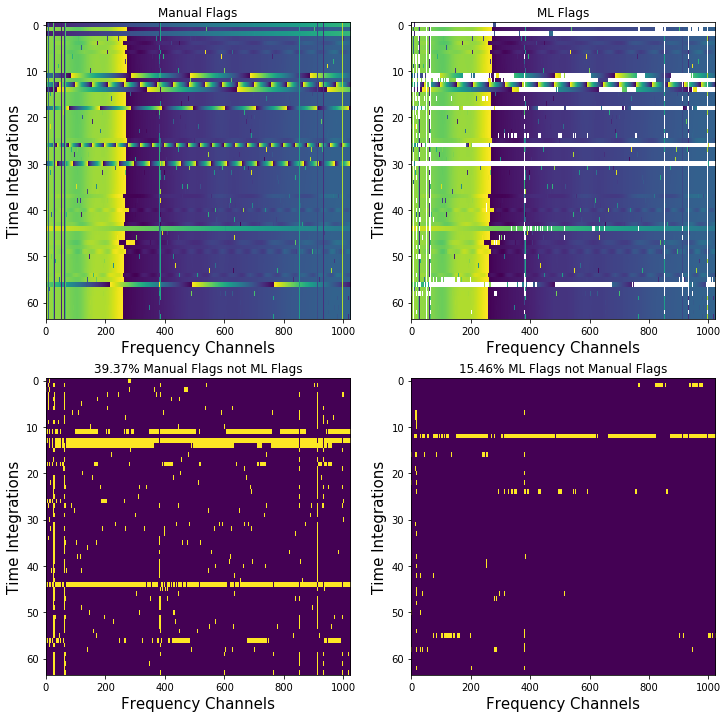

In [65]:
fig, axes = plt.subplots(figsize=(12,12), ncols=2, nrows=2)
ax = axes[0,0]
nan_array = np.ones_like(test_flag).astype(np.float64)
nan_array[test_flag == 1] = np.nan
ax.imshow(test_data_phs[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("Manual Flags")

ax = axes[0,1]
nan_array = np.ones_like(flags_out).astype(np.float64)
nan_array[flags_out == 1] = np.nan
ax.imshow((test_data_phs*nan_array)[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("ML Flags")

ax = axes[1,0]
ax.imshow(test_flag[0,:,:,0]*(1-flags_out[0,:,:,0]), aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
recall = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(test_flag[0,:,:,0])
ax.set_title("{0:.2f}% Manual Flags not ML Flags".format((1-recall)*100))

ax = axes[1,1]
ax.imshow((1-test_flag[0,:,:,0])*flags_out[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
precision = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(flags_out[0,:,:,0])
ax.set_title("{0:.2f}% ML Flags not Manual Flags".format((1-precision)*100))

### amplitude+phase input with three `layer':

In [66]:
def make_amp_phs_model_(input_shape):
    amp_input = Input(shape=input_shape, name="amp_input")
    phs_input = Input(shape=input_shape, name="phs_input")

    # amplitude branch
    ca1 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(amp_input)
    ca2 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(ca1)
    ca3 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(ca2)
    ma1 = MaxPooling2D(pool_size=2, strides=2)(ca3)
    la1 = LeakyReLU()(ma1)

    ca4 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(la1)
    ca5 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(ca4)
    ca6 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(ca5)
    ma2 = MaxPooling2D(pool_size=2, strides=2)(ca6)
    la2 = LeakyReLU()(ma2)
    
    ca7 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(la2)
    ca8 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(ca7)
    ca9 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(ca8)
    ma3 = MaxPooling2D(pool_size=2, strides=2)(ca9)
    la3 = LeakyReLU()(ma3)

    # phase branch
    cp1 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(phs_input)
    cp2 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(cp1)
    cp3 = Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(cp2)
    mp1 = MaxPooling2D(pool_size=2, strides=2)(cp3)
    lp1 = LeakyReLU()(mp1)

    cp4 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(lp1)
    cp5 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp4)
    cp6 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp5)
    mp2 = MaxPooling2D(pool_size=2, strides=2)(cp6)
    lp2 = LeakyReLU()(mp2)
    
    cp7 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(lp2)
    cp8 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp7)
    cp9 = Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(cp8)
    mp3 = MaxPooling2D(pool_size=2, strides=2)(cp9)
    lp3 = LeakyReLU()(mp3)

    # concatenate
    concat = concatenate([la3, lp3])

    # transpose layers
    tr1 = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same')(concat)
    tr2 = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same')(tr1)
    tr3 = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same')(tr2)
    bn1 = BatchNormalization()(tr3)
    act = Activation("softmax")(bn1)
    
    # build the model
    model = Model(inputs=[amp_input, phs_input], outputs=[act])
    
    return model

In [67]:
amp_phs_model = make_amp_phs_model_(input_shape)

In [68]:
amp_phs_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
amp_input (InputLayer)          [(None, 64, 1024, 1) 0                                            
__________________________________________________________________________________________________
phs_input (InputLayer)          [(None, 64, 1024, 1) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 64, 1024, 16) 160         amp_input[0][0]                  
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 64, 1024, 16) 160         phs_input[0][0]                  
____________________________________________________________________________________________

In [69]:
amp_phs_model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss="sparse_categorical_crossentropy",
         metrics=["sparse_categorical_accuracy",keras_recall_metric,keras_precision_metric, keras_f2_metric]) 

In [70]:
#cb = keras.callbacks.TensorBoard(log_dir="./",
#                     histogram_freq=10, write_images=True)
trainingStopCallback = haltCallback()
amp_phs_model.fit(
    [train_data_amp,train_data_phs],
    train_flag,
    validation_data=([test_data_amp, test_data_phs], test_flag),
    epochs=200,
    batch_size=32
)

Train on 100 samples, validate on 20 samples
Epoch 1/200
100/100 [==============================] - 2s 25ms/sample - loss: 0.9117 - sparse_categorical_accuracy: 0.5190 - keras_recall_metric: 0.4666 - keras_precision_metric: 0.2276 - keras_f2_metric: 0.3852 - val_loss: 0.7207 - val_sparse_categorical_accuracy: 0.4918 - val_keras_recall_metric: 0.5634 - val_keras_precision_metric: 0.2354 - val_keras_f2_metric: 0.4406
Epoch 2/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.8702 - sparse_categorical_accuracy: 0.5561 - keras_recall_metric: 0.4178 - keras_precision_metric: 0.2355 - keras_f2_metric: 0.3612 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.5508 - val_keras_recall_metric: 0.4282 - val_keras_precision_metric: 0.2302 - val_keras_f2_metric: 0.3654
Epoch 3/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.8331 - sparse_categorical_accuracy: 0.5804 - keras_recall_metric: 0.3674 - keras_precision_metric: 0.2318 - keras_f2_metric: 0.32

Epoch 23/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.6548 - sparse_categorical_accuracy: 0.7616 - keras_recall_metric: 0.1379 - keras_precision_metric: 0.4240 - keras_f2_metric: 0.1594 - val_loss: 0.6559 - val_sparse_categorical_accuracy: 0.7641 - val_keras_recall_metric: 0.1411 - val_keras_precision_metric: 0.4223 - val_keras_f2_metric: 0.1628
Epoch 24/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.6515 - sparse_categorical_accuracy: 0.7667 - keras_recall_metric: 0.1210 - keras_precision_metric: 0.4474 - keras_f2_metric: 0.1416 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.7671 - val_keras_recall_metric: 0.1391 - val_keras_precision_metric: 0.4393 - val_keras_f2_metric: 0.1611
Epoch 25/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.6482 - sparse_categorical_accuracy: 0.7656 - keras_recall_metric: 0.1437 - keras_precision_metric: 0.4354 - keras_f2_metric: 0.1659 - val_loss: 0.6466 - val_sparse_categori

Epoch 45/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.5248 - sparse_categorical_accuracy: 0.7857 - keras_recall_metric: 0.4579 - keras_precision_metric: 0.5167 - keras_f2_metric: 0.4680 - val_loss: 0.5640 - val_sparse_categorical_accuracy: 0.7848 - val_keras_recall_metric: 0.4192 - val_keras_precision_metric: 0.5252 - val_keras_f2_metric: 0.4368
Epoch 46/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.5158 - sparse_categorical_accuracy: 0.7863 - keras_recall_metric: 0.4565 - keras_precision_metric: 0.5189 - keras_f2_metric: 0.4674 - val_loss: 0.5289 - val_sparse_categorical_accuracy: 0.8042 - val_keras_recall_metric: 0.3675 - val_keras_precision_metric: 0.6043 - val_keras_f2_metric: 0.3987
Epoch 47/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.5063 - sparse_categorical_accuracy: 0.7927 - keras_recall_metric: 0.4618 - keras_precision_metric: 0.5515 - keras_f2_metric: 0.4771 - val_loss: 0.5384 - val_sparse_categori

Epoch 67/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.4079 - sparse_categorical_accuracy: 0.8630 - keras_recall_metric: 0.4978 - keras_precision_metric: 0.7896 - keras_f2_metric: 0.5373 - val_loss: 0.4422 - val_sparse_categorical_accuracy: 0.8477 - val_keras_recall_metric: 0.4959 - val_keras_precision_metric: 0.7391 - val_keras_f2_metric: 0.5308
Epoch 68/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.4044 - sparse_categorical_accuracy: 0.8646 - keras_recall_metric: 0.5125 - keras_precision_metric: 0.8244 - keras_f2_metric: 0.5544 - val_loss: 0.4298 - val_sparse_categorical_accuracy: 0.8599 - val_keras_recall_metric: 0.4648 - val_keras_precision_metric: 0.8384 - val_keras_f2_metric: 0.5103
Epoch 69/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.4013 - sparse_categorical_accuracy: 0.8673 - keras_recall_metric: 0.4813 - keras_precision_metric: 0.8006 - keras_f2_metric: 0.5230 - val_loss: 0.4246 - val_sparse_categori

Epoch 89/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.3686 - sparse_categorical_accuracy: 0.8737 - keras_recall_metric: 0.4993 - keras_precision_metric: 0.8947 - keras_f2_metric: 0.5477 - val_loss: 0.3869 - val_sparse_categorical_accuracy: 0.8688 - val_keras_recall_metric: 0.4578 - val_keras_precision_metric: 0.9146 - val_keras_f2_metric: 0.5086
Epoch 90/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.3693 - sparse_categorical_accuracy: 0.8719 - keras_recall_metric: 0.5099 - keras_precision_metric: 0.8579 - keras_f2_metric: 0.5542 - val_loss: 0.4111 - val_sparse_categorical_accuracy: 0.8528 - val_keras_recall_metric: 0.5199 - val_keras_precision_metric: 0.7469 - val_keras_f2_metric: 0.5536
Epoch 91/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3675 - sparse_categorical_accuracy: 0.8726 - keras_recall_metric: 0.5021 - keras_precision_metric: 0.8903 - keras_f2_metric: 0.5500 - val_loss: 0.3769 - val_sparse_categori

Epoch 111/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3474 - sparse_categorical_accuracy: 0.8767 - keras_recall_metric: 0.5414 - keras_precision_metric: 0.8519 - keras_f2_metric: 0.5837 - val_loss: 0.3734 - val_sparse_categorical_accuracy: 0.8670 - val_keras_recall_metric: 0.5230 - val_keras_precision_metric: 0.8184 - val_keras_f2_metric: 0.5637
Epoch 112/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3452 - sparse_categorical_accuracy: 0.8758 - keras_recall_metric: 0.5369 - keras_precision_metric: 0.8543 - keras_f2_metric: 0.5799 - val_loss: 0.3636 - val_sparse_categorical_accuracy: 0.8731 - val_keras_recall_metric: 0.5184 - val_keras_precision_metric: 0.8602 - val_keras_f2_metric: 0.5632
Epoch 113/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.3428 - sparse_categorical_accuracy: 0.8795 - keras_recall_metric: 0.5316 - keras_precision_metric: 0.8924 - keras_f2_metric: 0.5781 - val_loss: 0.3615 - val_sparse_categ

Epoch 133/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3262 - sparse_categorical_accuracy: 0.8839 - keras_recall_metric: 0.5727 - keras_precision_metric: 0.8789 - keras_f2_metric: 0.6153 - val_loss: 0.3485 - val_sparse_categorical_accuracy: 0.8729 - val_keras_recall_metric: 0.5287 - val_keras_precision_metric: 0.8468 - val_keras_f2_metric: 0.5716
Epoch 134/200
100/100 [==============================] - 1s 9ms/sample - loss: 0.3273 - sparse_categorical_accuracy: 0.8763 - keras_recall_metric: 0.5896 - keras_precision_metric: 0.8211 - keras_f2_metric: 0.6247 - val_loss: 0.3568 - val_sparse_categorical_accuracy: 0.8708 - val_keras_recall_metric: 0.5553 - val_keras_precision_metric: 0.8086 - val_keras_f2_metric: 0.5924
Epoch 135/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.3259 - sparse_categorical_accuracy: 0.8824 - keras_recall_metric: 0.5808 - keras_precision_metric: 0.8648 - keras_f2_metric: 0.6216 - val_loss: 0.3445 - val_sparse_categ

Epoch 155/200
100/100 [==============================] - 1s 9ms/sample - loss: 0.3147 - sparse_categorical_accuracy: 0.8836 - keras_recall_metric: 0.6280 - keras_precision_metric: 0.8369 - keras_f2_metric: 0.6605 - val_loss: 0.3474 - val_sparse_categorical_accuracy: 0.8640 - val_keras_recall_metric: 0.5869 - val_keras_precision_metric: 0.7521 - val_keras_f2_metric: 0.6139
Epoch 156/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3169 - sparse_categorical_accuracy: 0.8779 - keras_recall_metric: 0.5753 - keras_precision_metric: 0.7808 - keras_f2_metric: 0.6069 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.8708 - val_keras_recall_metric: 0.5512 - val_keras_precision_metric: 0.8126 - val_keras_f2_metric: 0.5891
Epoch 157/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3177 - sparse_categorical_accuracy: 0.8821 - keras_recall_metric: 0.6006 - keras_precision_metric: 0.8519 - keras_f2_metric: 0.6374 - val_loss: 0.3325 - val_sparse_categ

Epoch 177/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3024 - sparse_categorical_accuracy: 0.8834 - keras_recall_metric: 0.6162 - keras_precision_metric: 0.8360 - keras_f2_metric: 0.6500 - val_loss: 0.3219 - val_sparse_categorical_accuracy: 0.8719 - val_keras_recall_metric: 0.5479 - val_keras_precision_metric: 0.8215 - val_keras_f2_metric: 0.5870
Epoch 178/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3018 - sparse_categorical_accuracy: 0.8832 - keras_recall_metric: 0.6323 - keras_precision_metric: 0.8345 - keras_f2_metric: 0.6643 - val_loss: 0.3356 - val_sparse_categorical_accuracy: 0.8676 - val_keras_recall_metric: 0.6072 - val_keras_precision_metric: 0.7544 - val_keras_f2_metric: 0.6319
Epoch 179/200
100/100 [==============================] - 1s 8ms/sample - loss: 0.3004 - sparse_categorical_accuracy: 0.8858 - keras_recall_metric: 0.6176 - keras_precision_metric: 0.8084 - keras_f2_metric: 0.6481 - val_loss: 0.3191 - val_sparse_categ

Epoch 199/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.2905 - sparse_categorical_accuracy: 0.8918 - keras_recall_metric: 0.6461 - keras_precision_metric: 0.8384 - keras_f2_metric: 0.6769 - val_loss: 0.3290 - val_sparse_categorical_accuracy: 0.8681 - val_keras_recall_metric: 0.5869 - val_keras_precision_metric: 0.7701 - val_keras_f2_metric: 0.6162
Epoch 200/200
100/100 [==============================] - 1s 7ms/sample - loss: 0.2893 - sparse_categorical_accuracy: 0.8913 - keras_recall_metric: 0.6540 - keras_precision_metric: 0.8040 - keras_f2_metric: 0.6793 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 0.8685 - val_keras_recall_metric: 0.5236 - val_keras_precision_metric: 0.8262 - val_keras_f2_metric: 0.5650


In [71]:
flags = amp_phs_model.predict([test_data_amp, test_data_phs])
flags_out = keras_unpad_flags(flags)[:,:,:,None]

Text(0.5, 1.0, '11.89% ML Flags not Manual Flags')

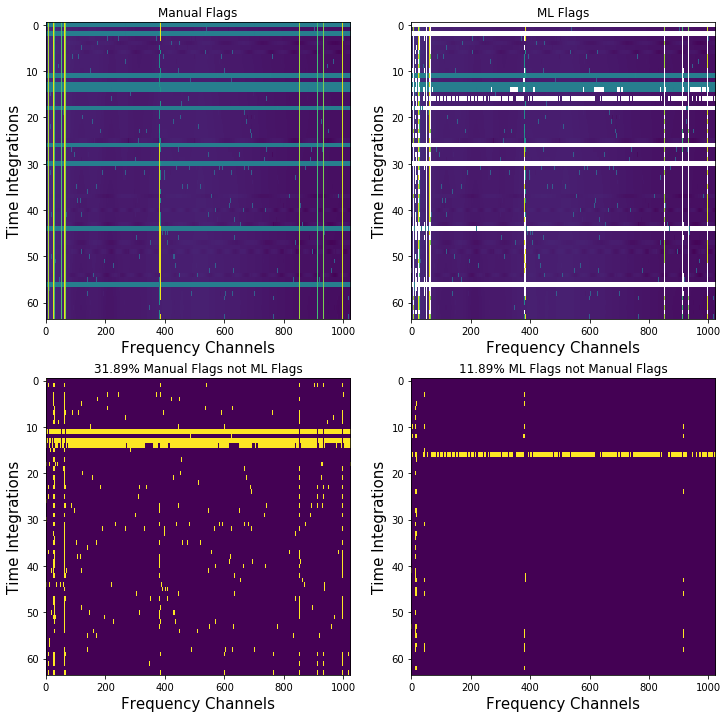

In [72]:
fig, axes = plt.subplots(figsize=(12,12), ncols=2, nrows=2)
ax = axes[0,0]
nan_array = np.ones_like(test_flag).astype(np.float64)
nan_array[test_flag == 1] = np.nan
ax.imshow(test_data_amp[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("Manual Flags")

ax = axes[0,1]
nan_array = np.ones_like(flags_out).astype(np.float64)
nan_array[flags_out == 1] = np.nan
ax.imshow((test_data_amp*nan_array)[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
ax.set_title("ML Flags")

ax = axes[1,0]
ax.imshow(test_flag[0,:,:,0]*(1-flags_out[0,:,:,0]), aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
recall = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(test_flag[0,:,:,0])
ax.set_title("{0:.2f}% Manual Flags not ML Flags".format((1-recall)*100))

ax = axes[1,1]
ax.imshow((1-test_flag[0,:,:,0])*flags_out[0,:,:,0], aspect='auto')
ax.set_xlabel("Frequency Channels", fontsize=15)
ax.set_ylabel("Time Integrations", fontsize=15)
precision = np.sum(test_flag[0,:,:,0]*flags_out[0,:,:,0])/np.sum(flags_out[0,:,:,0])
ax.set_title("{0:.2f}% ML Flags not Manual Flags".format((1-precision)*100))

In [56]:
#val_keras_recall_metric: 0.4739 - val_keras_precision_metric: 0.8898 - val_keras_f2_metric: 0.5228 200

In [57]:
#val_keras_recall_metric: 0.4549 - val_keras_precision_metric: 0.8606 - val_keras_f2_metric: 0.5022, 200

In [58]:
#val_keras_recall_metric: 0.5805 - val_keras_precision_metric: 0.8900 - val_keras_f2_metric: 0.6238 144

In [59]:
#val_keras_recall_metric: 0.6017 - val_keras_precision_metric: 0.8835 - val_keras_f2_metric: 0.6426, 42

In [60]:
#val_keras_recall_metric: 0.6141 - val_keras_precision_metric: 0.8073 - val_keras_f2_metric: 0.6449, 47

In [61]:
#val_keras_recall_metric: 0.4301 - val_keras_precision_metric: 0.7619 - val_keras_f2_metric: 0.4711, 105

In [1]:
"""
recall = [0.4431, 0.4739, 0.4549, 0.5805, 0.6017 , 0.6141,0.4301 ]
precision = [0.8231,0.8898,0.8606,0.8900,0.8835,0.8073,0.7619  ]
f2 = [0.4881, 0.5228, 0.5022, 0.6238, 0.6426, 0.6449, 0.4711  ]
Epoch = [200,200,200,144,42,47,105]
names = ["one layer", "one layer \n with more \n LeakyRelu", "one layer \n with one \n more conv", "two layer", "three layer", "four layer", "five layer"]
"""

Text(0, 0.5, 'Epochs to reach 0.15 loss')

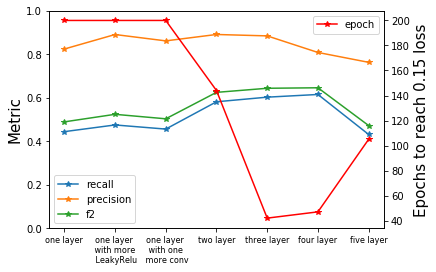

In [4]:
"""
fig, ax = plt.subplots()
ax.plot(recall, marker="*", label="recall")
ax.plot(precision,marker="*",label="precision")
ax.plot(f2,marker="*",label='f2')
ax.set_ylim(0,1)
ax.set_ylabel("Metric",fontsize=15)
ax.legend()
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(names, fontsize=8)
axt = ax.twinx()
axt.plot(Epoch,marker="*",label="epoch",c='r')
axt.legend()
axt.set_ylabel("Epochs to reach 0.15 loss",fontsize=15)
"""